# FEM-BEM coupling of Poisson-Boltzmann - Arginine varying permitivity

## Entry data

In [1]:
import dolfin
import bempp.api
from bempp.api.external.fenics import FenicsOperator
from dolfin_utils.meshconvert import meshconvert
import numpy as np
from bempp.api.external import fenics
from scipy.sparse.linalg import cg, minres
import pylab as plt
import time

from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
from bempp.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator

from bempp.api.operators.boundary import sparse, laplace, modified_helmholtz
from bempp.api.operators.potential import laplace as lp
from scipy.sparse import diags
 
# Problem data #
tol = 1e-06         # Tolerance
fmm = 0             # Use FMM

# Problem data #
from readpqr_all import readpqr_all
[PC, Q, R] = readpqr_all('./arginine/arg.pqr')         # Charges, Points of charges and Radiuses
w = 0.1250                                             # kappa
es = 80.                                               # External permitivity (solvant)
em = 2.                                                # Internal permitivity (molecule)

ec = 1.602176e-19 #[C]
kb = 1.380648e-23 #[J/K]
T  = 298.15 #[K]
S1 = 1 #(ec/(kb*T))  #38.681 [C/J]

# Result collecting lists #
solv_error = []
mesh_size = []
iter_num = []
time_solve = []
time_set = []
vac_iter_num = []
vac_time_solve = []

# Iteratotion for mesh #
grid_size = [2, 4, 8, 16]

###### Function evaluating coefficient values from analitycal expression on BEM Gaussian Points
@bempp.api.real_callable(jit=False)
def epsilon_b(x, n, domain_index, result):
    global PC,R,em,es
    rho = np.prod(1-np.exp(-(np.linalg.norm( x - PC, axis=1)**2)/(R**2)))
    result[:] = (es - em)*rho + em 
     
###### Function evaluating coefficient values from analitycal expression on FEM Gaussian Points
rho_fem = dolfin.Constant(1.0)
for i in range(len(R)):
    e_prod = dolfin.Expression('1 - exp(-((x[0] - PC1)*(x[0] - PC1) + (x[1] - PC2)*(x[1] - PC2) + (x[2] - PC3)*(x[2] - PC3))/(Ri*Ri))', PC1=PC[i][0], PC2=PC[i][1], PC3=PC[i][2], Ri=R[i], degree=1)         
    rho_fem = rho_fem * e_prod 
                 
epsilon_fem = dolfin.Expression('(epsilonS-epsilonM)', epsilonM=em, epsilonS=es, degree=0)*rho_fem+dolfin.Expression('epsilon', epsilon=em, degree=0)

## Solving problems for each of the mesh

In [2]:
for m in grid_size:
    ######################### Mesh and spaces ##################################
#     mesh = dolfin.Mesh("./arginine/arg_d0"+format(m)+"_surf.xml")
    mesh = dolfin.Mesh("./arginine/arg_d0"+format(m)+"_11.xml")
    nor = dolfin.FacetNormal(mesh) 
    
    # Spaces for FEM and BEM
    fenics_space = dolfin.FunctionSpace(mesh, "CG", 1)
    trace_space, trace_matrix = \
        fenics.fenics_to_bempp_trace_data(fenics_space)
    bempp_space = bempp.api.function_space(trace_space.grid, "P", 1)

    # Mesh size information #
    print("FEM dofs: {0}".format(mesh.num_vertices()))
    print("BEM dofs: {0}".format(bempp_space.global_dof_count))
    hmax = trace_space.grid.maximum_element_diameter
    mesh_size.append(hmax)
    
    epsilon_bem = bempp.api.GridFunction(trace_space, fun=epsilon_b)
    
    # FEM discrete variables
    u = dolfin.TrialFunction(fenics_space)
    v = dolfin.TestFunction(fenics_space)
    
    # Starting set-up time
    start = time.time()     
    
    # BEM operators
    id_op = bempp.api.operators.boundary.sparse.identity(trace_space, bempp_space, bempp_space)
    mass = bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, trace_space)

    if fmm:
        dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, bempp_space, bempp_space, assembler="fmm")
        slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, bempp_space, bempp_space, assembler="fmm")

        dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, bempp_space, bempp_space, w, assembler="fmm")
        slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, bempp_space, bempp_space, w, assembler="fmm")
    else:
        dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, bempp_space, bempp_space)
        slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, bempp_space, bempp_space)

        dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, bempp_space, bempp_space, w)
        slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, bempp_space, bempp_space, w)

    ######################### Matrix and RHS ##################################
    
    # RHS for FEM
    rhs_f = dolfin.Constant(0.0)
    rhs_fem = dolfin.assemble(rhs_f*v*dolfin.dx)
    for i in range(len(PC)):
        delta = dolfin.PointSource(fenics_space, dolfin.Point(PC[i]), Q[i])
        delta.apply(rhs_fem)
    # RHS for BEM
    rhs_bem = np.zeros(bempp_space.global_dof_count)
    # Global RHS
    rhs = np.concatenate([rhs_fem, rhs_bem])
    
    blocks = [[None,None],[None,None]]
    blocks_vac = [[None,None],[None,None]]
    
    # FEM matrices
    trace_op = LinearOperator(trace_matrix.shape, lambda x:trace_matrix*x)
    
    A_epsilon = FenicsOperator((epsilon_fem*dolfin.inner(dolfin.nabla_grad(u),
                                     dolfin.nabla_grad(v)) ) * dolfin.dx) 
    
    # Solvant case
    blocks[0][0] = A_epsilon.weak_form()
    blocks[0][1] = -trace_matrix.T @(diags(epsilon_bem.coefficients)@mass.weak_form().A)
    blocks[1][0] = (.5 * id_op - dlp).weak_form() * trace_op
    blocks[1][1] = slp.weak_form().A*(epsilon_bem.coefficients/es)

    blocked = BlockedDiscreteOperator(np.array(blocks))
    
    # Vaccum case
    blocks_vac[0][0] = A_epsilon.weak_form()
    blocks_vac[0][1] = -trace_matrix.T @(diags(epsilon_bem.coefficients)@mass.weak_form().A)
    blocks_vac[1][0] = (.5 * id_op - dlp_0).weak_form() * trace_op
    blocks_vac[1][1] = slp_0.weak_form().A*(epsilon_bem.coefficients/em)

    blocked_vacuum = BlockedDiscreteOperator(np.array(blocks_vac))
    
    ######################### Preconditioner and solvers ##################################
    
    # Diagonal Scaling #
    P1 = diags(1./blocked[0,0].A.diagonal())

    # Mass matrix preconditioner #
    P2 = InverseSparseDiscreteBoundaryOperator(
        bempp.api.operators.boundary.sparse.identity(
            bempp_space, bempp_space, bempp_space).weak_form())

    # Create a block diagonal preconditioner object using the Scipy LinearOperator class
    def apply_prec(x):
        """Apply the block diagonal preconditioner"""
        m1 = P1.shape[0]
        m2 = P2.shape[0]
        n1 = P1.shape[1]
        n2 = P2.shape[1]

        res1 = P1.dot(x[:n1]) 
        res2 = P2.dot(x[n1:])
        return np.concatenate([res1, res2])

    p_shape = (P1.shape[0] + P2.shape[0], P1.shape[1] + P2.shape[1])
    P = LinearOperator(p_shape, apply_prec, dtype=np.dtype('float64'))
        
    end = time.time()
    set_time = (end - start) 
    time_set.append(set_time) 

    # Solvant case
    it_count = 0
    def count_iterations(x):
        global it_count
        it_count += 1

    from scipy.sparse.linalg import gmres
    start = time.time()     
    soln, info = gmres(blocked, rhs, M=P, callback=count_iterations, tol=tol, restrt=500)  
    end = time.time()
    curr_time = (end - start) 
    time_solve.append(curr_time) 
                       
    soln_fem = soln[:mesh.num_vertices()]
    soln_bem = soln[mesh.num_vertices():]

    print("Number of iterations: {0}".format(it_count))
    iter_num.append(it_count)
    
    u = dolfin.Function(fenics_space)
    u.vector()[:] = np.ascontiguousarray(np.real(soln_fem))
    dirichlet_data = trace_matrix * soln_fem
    dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=dirichlet_data)
    neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=soln_bem)
    
    # Vaccum case
    it_count = 0
    start = time.time()     
    soln_vacuum, info = gmres(blocked_vacuum, rhs, M=P, callback=count_iterations, tol=tol, restrt=500)  
    end = time.time()
    curr_time = (end - start) 
    vac_time_solve.append(curr_time) 
                       
    vac_soln_fem = soln_vacuum[:mesh.num_vertices()]
    vac_soln_bem = soln_vacuum[mesh.num_vertices():]

    print("Number of iterations (vacuum case): {0}".format(it_count))
    vac_iter_num.append(it_count)
    
    u_vac = dolfin.Function(fenics_space)
    u_vac.vector()[:] = np.ascontiguousarray(np.real(vac_soln_fem))
    vac_dirichlet_data = trace_matrix * vac_soln_fem
    vac_dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=vac_dirichlet_data)
    vac_neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=vac_soln_bem)
    
    ######################### Solvation energy ##################################
    
    q_uF = 0
    for i in range(len(PC)):
        Sum =  u(PC[i])*Q[i] - u_vac(PC[i])*Q[i]
        q_uF = q_uF + Sum

    E_Solv = 0.5*4.*np.pi*332.064*(q_uF) 
    print('Energia de Solvatacion (FEM): {:7.3f} [kCal/mol]'.format(E_Solv))
    
    solv_error.append(E_Solv)

FEM dofs: 972
BEM dofs: 403
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
<ipython-input-2-3de7a4c0cd6f>:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  blocked = BlockedDiscreteOperator(np.array(blocks))
<ipython-input-2-3de7a4c0cd6f>:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  blocked_vacuum = BlockedDiscreteOperator(np.array(blocks_vac))


Number of iterations: 158
Number of iterations (vacuum case): 172
Energia de Solvatacion (FEM): -37.298 [kCal/mol]
FEM dofs: 2187
BEM dofs: 825
Number of iterations: 134
Number of iterations (vacuum case): 211
Energia de Solvatacion (FEM): -36.142 [kCal/mol]
FEM dofs: 4003
BEM dofs: 1572
Number of iterations: 204
Number of iterations (vacuum case): 362
Energia de Solvatacion (FEM): -35.536 [kCal/mol]
FEM dofs: 8190
BEM dofs: 3262
Number of iterations: 120
Number of iterations (vacuum case): 308
Energia de Solvatacion (FEM): -35.170 [kCal/mol]


## Ploting the results and saving for comparison to BEM-BEM and FEM-BEM coupling formulations

## Solvation Energy Error

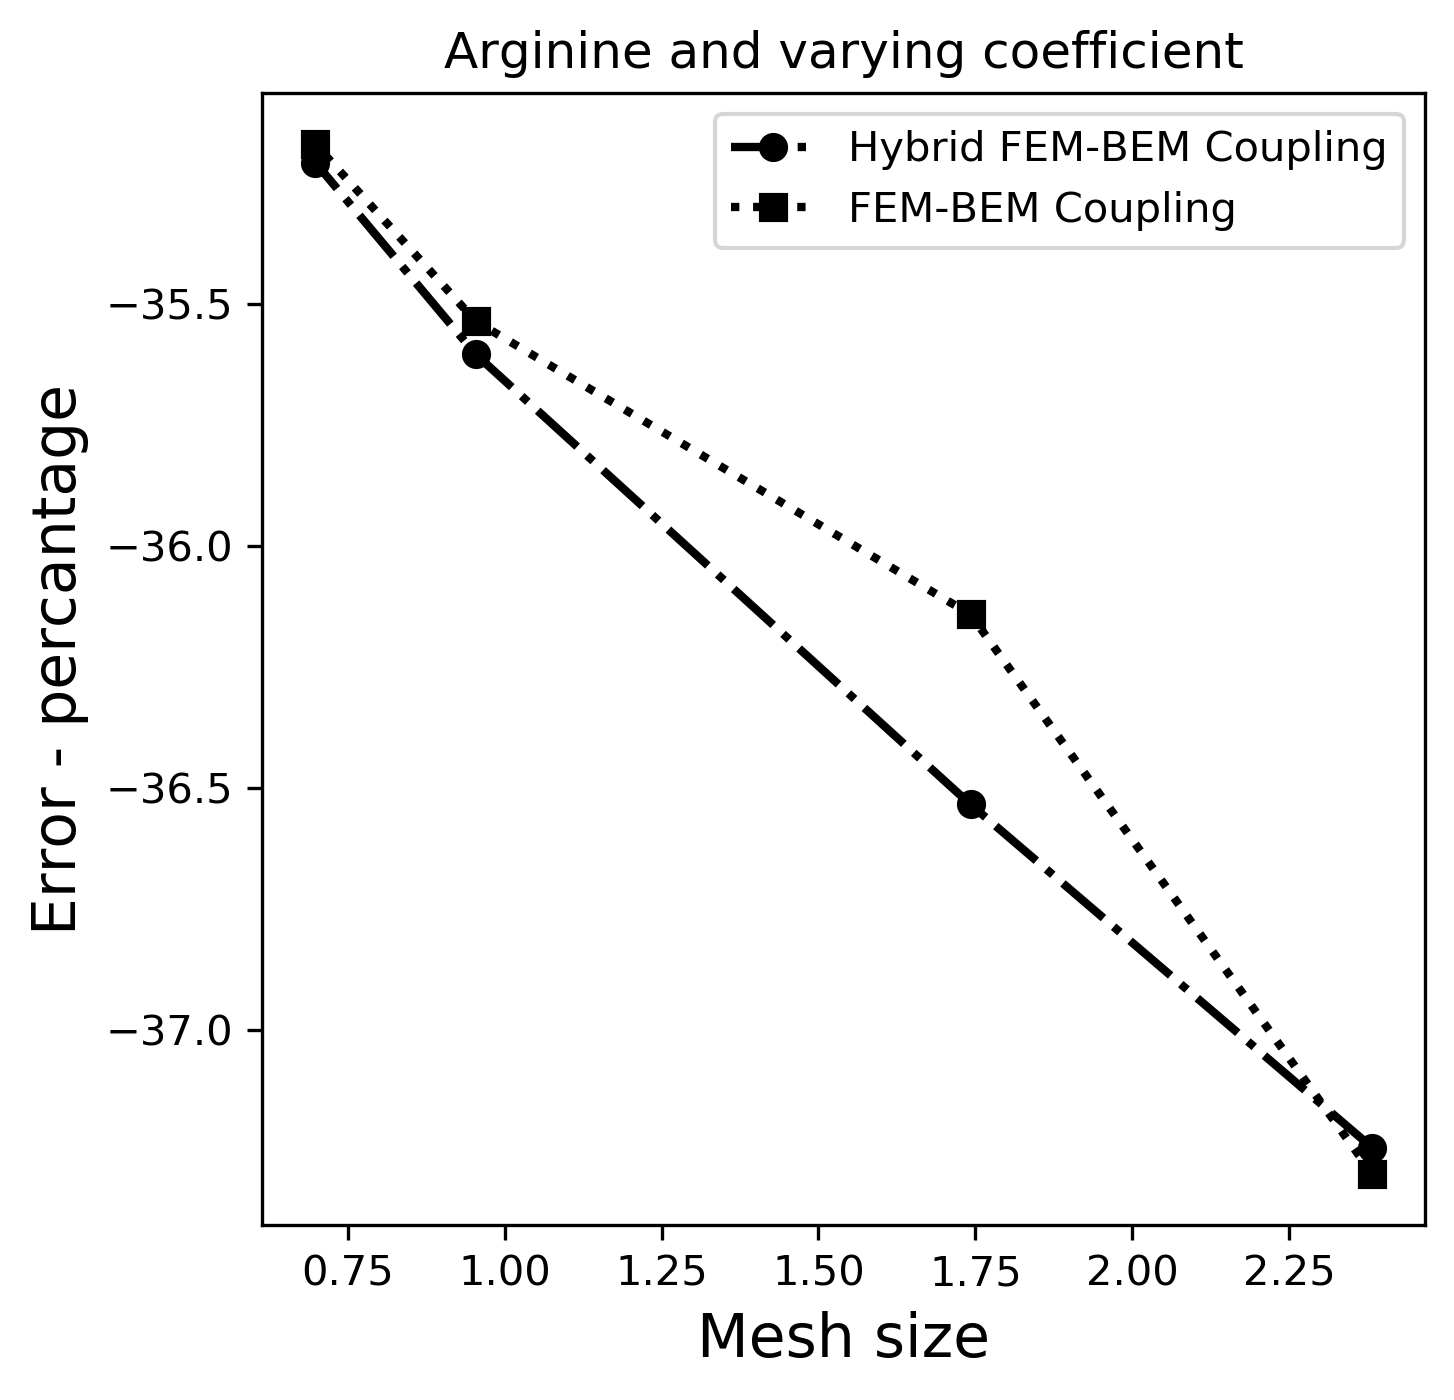

In [3]:
from operator import add
import matplotlib.pyplot as plt

with open('Hybrid_FEM_BEM_Arginine_varying_error.npy', 'rb') as f:
     Hybrid_FEM_BEM_solv_error = np.load(f)

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, Hybrid_FEM_BEM_solv_error, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
plt.plot(mesh_size, solv_error, 'ks:', linewidth=2, label='FEM-BEM Coupling')
# plt.loglog(mesh_size, o_mesh_size, 'k:', linewidth=1, label='O(h)')
plt.legend(loc='best')
plt.title('Arginine and varying coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Error - percantage', fontsize='x-large')
plt.show()

## Iteration count

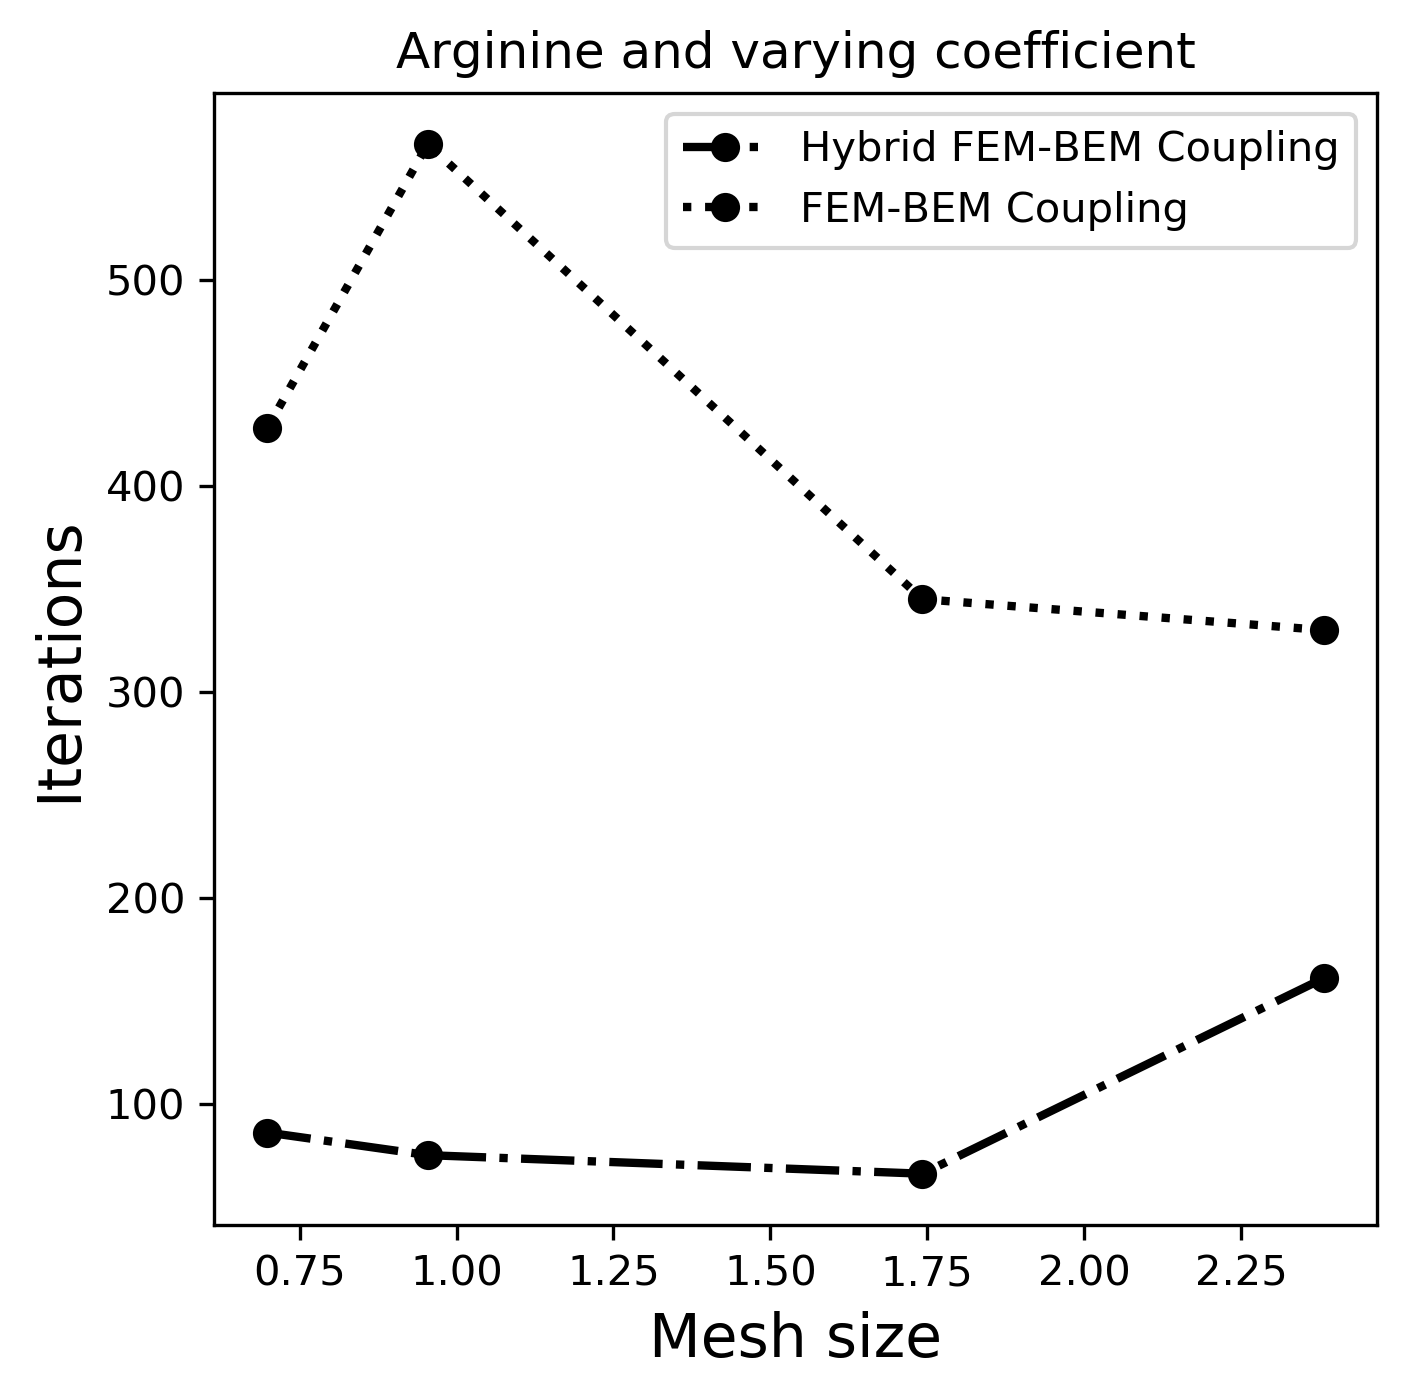

In [4]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('Hybrid_FEM_BEM_Arginine_varying_iter.npy', 'rb') as f:
     Hybrid_FEM_BEM_solv_iter = np.load(f)

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, Hybrid_FEM_BEM_solv_iter, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
plt.plot(mesh_size, np.add(iter_num, vac_iter_num), 'ko:', linewidth=2, label='FEM-BEM Coupling')
plt.legend(loc='best')
plt.title('Arginine and varying coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Iterations', fontsize='x-large')
plt.show()

## Computational cost

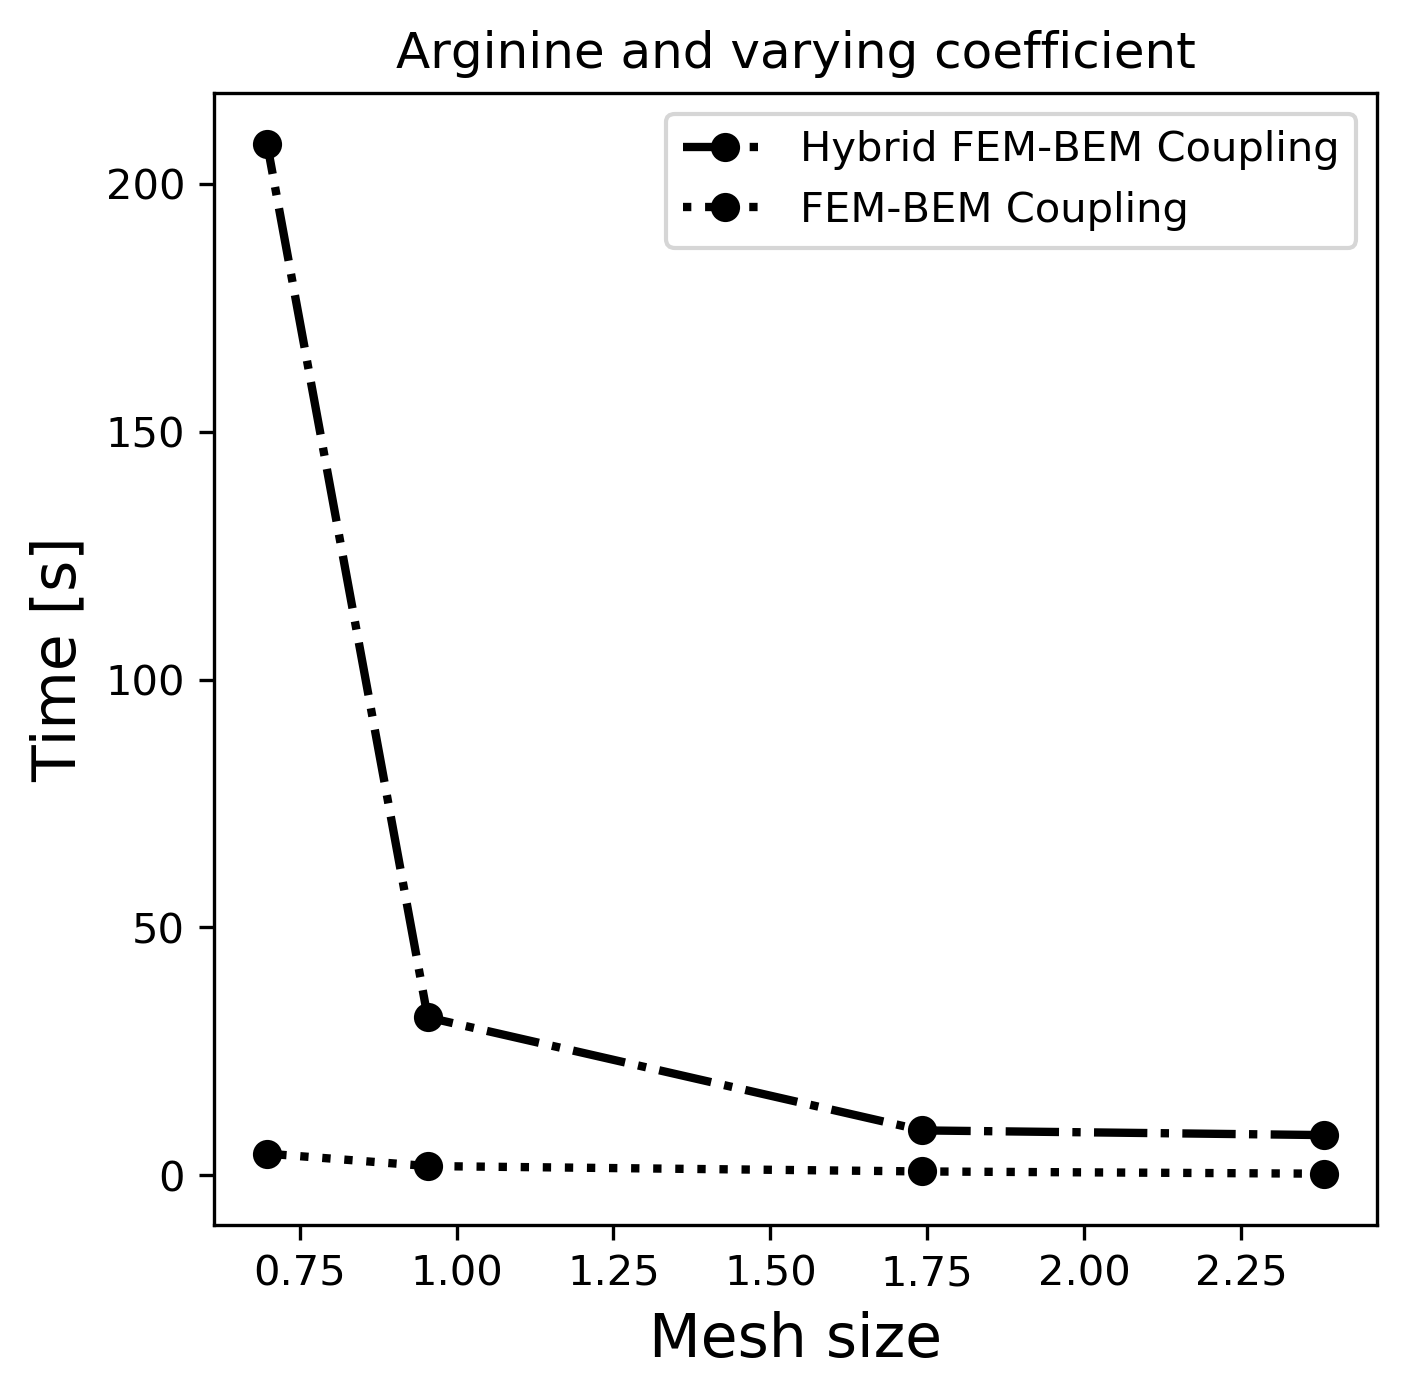

In [5]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('Hybrid_FEM_BEM_Arginine_varying_time.npy', 'rb') as f:
     Hybrid_FEM_BEM_solv_time = np.load(f)

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, Hybrid_FEM_BEM_solv_time, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
plt.plot(mesh_size, np.add(time_solve, vac_time_solve), 'ko:', linewidth=2, label='FEM-BEM Coupling')
plt.legend(loc='best')
plt.title('Arginine and varying coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()

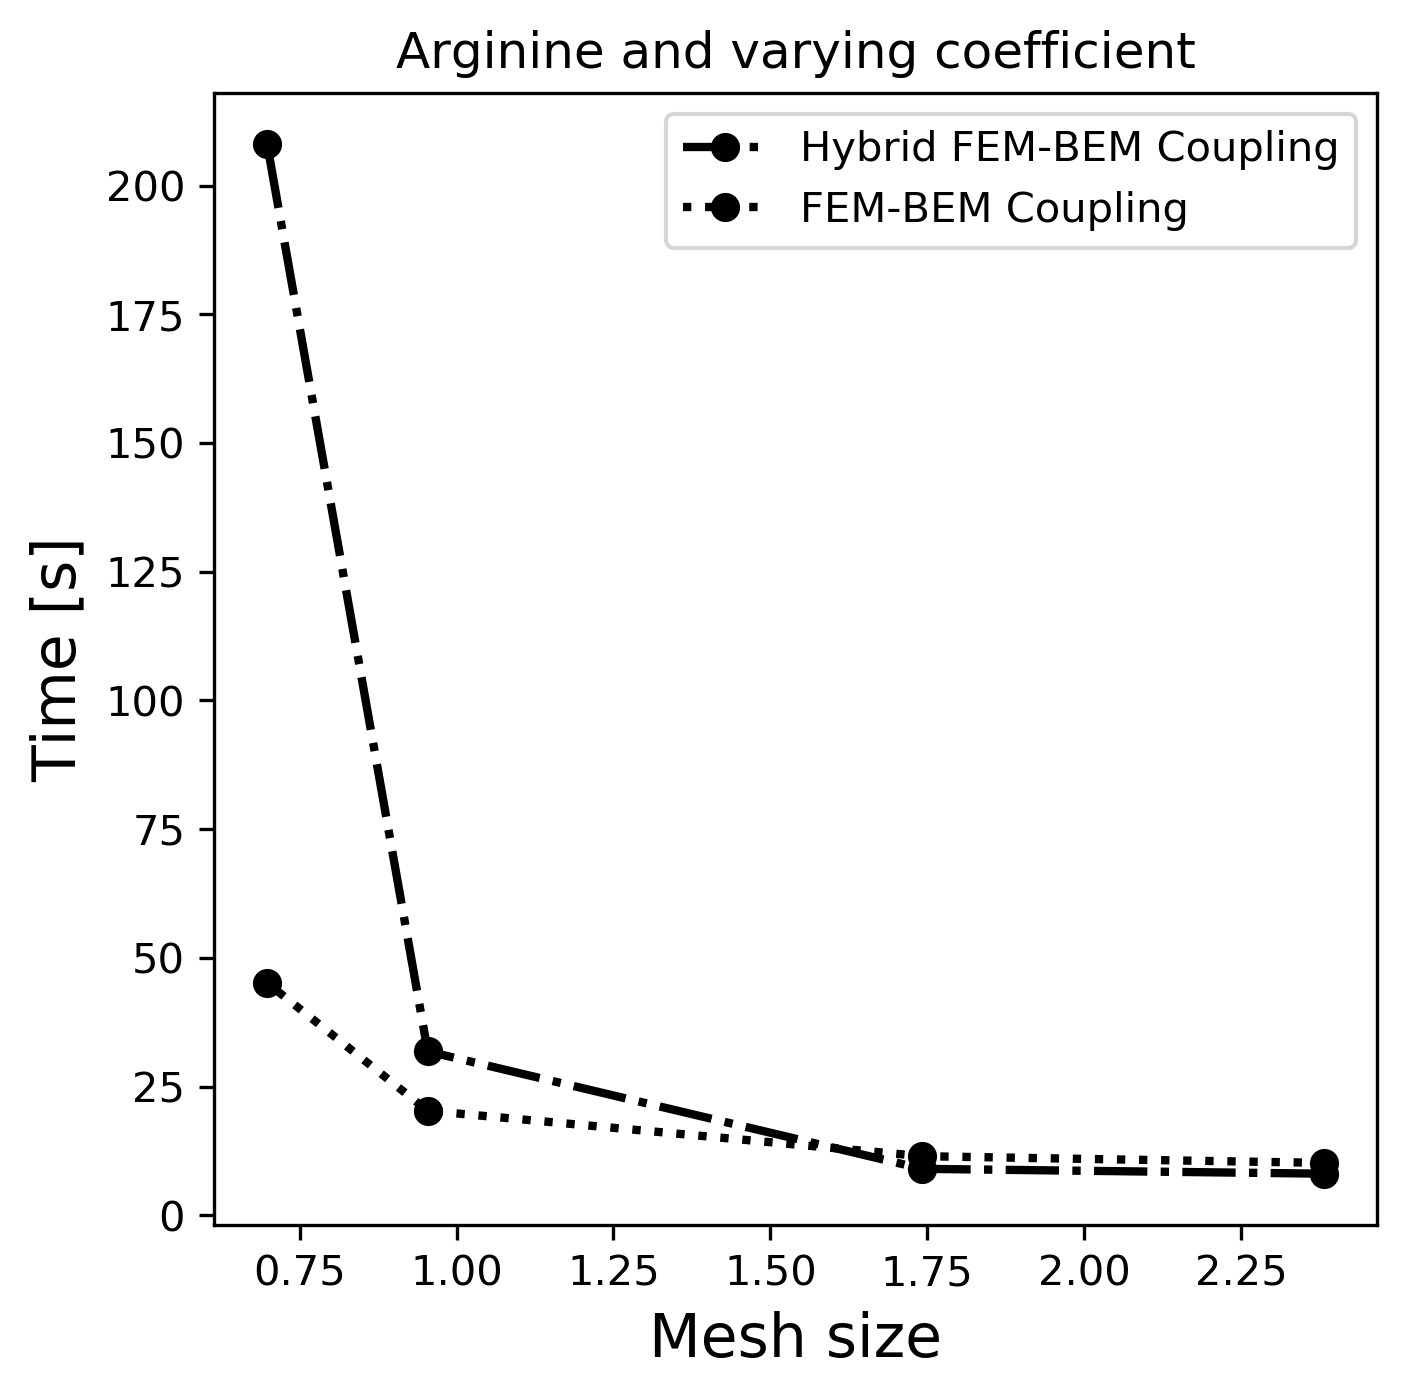

In [6]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('Hybrid_FEM_BEM_Arginine_varying_time_assemble.npy', 'rb') as f:
     Hybrid_FEM_BEM_solv_time = np.load(f)

plt.figure( figsize=(5, 5), dpi=300)
plt.plot(mesh_size, Hybrid_FEM_BEM_solv_time, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
plt.plot(mesh_size, time_set, 'ko:', linewidth=2, label='FEM-BEM Coupling')
plt.legend(loc='best')
plt.title('Arginine and varying coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()